# CNN with Tranfer Learning

In [1]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

Google Colab에서 실행할 경우 위 주석을 해제하고 실행하면 됨. Colab에는 pytorch가 설치되어있지 않으므로 설치 필요.

In [1]:
import torch
import torch.nn as nn

In [2]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

In [3]:
import torchvision
from torchvision import models
from torchvision import datasets
from torchvision import transforms

In [4]:
from PIL import Image

**torch**: pytorch의 가장 상위에 있는 package로써 라이브러리에서 이것저것 불러오기 위해 import

**torch.nn**: 모델을 정의할 때 사용하는 Class들을 포함하고 있음.

**torchvision**: Computer vision에서 사용하는 각종 테크닉들을 torch와 연동하여 구현한 라이브러리.

**torch.utils.data**: Data와 관련된 라이브러리

In [5]:
import numpy as np
import datetime
import os, sys
import glob

**numpy**: python으로 data science를 할 때 가장 기본이 되는 라이브러리 중 하나. 각종 행렬 연산에 필요한 함수들을 다수 포함하고 있음.

**datetime**: 시간찍을려고...

**os, sys**: os로부터 정보를 얻고 싶을 때 쓰는 라이브러리

**glob**: file system with re

In [6]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

**matplotlib**는 python visualization library

In [7]:
MODEL_NAME = 'CNN-Advanced'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU가 있다면 GPU를 통해 학습을 가속화하고, 없으면 CPU로 학습하기 위해 device를 정해준다.

**torch.cuda.is_avaliable()**은 GPU가 사용가능한지를 판단하는 함수

In [8]:
class ResNet(models.resnet.ResNet):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__(block, layers, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        features = x.view(x.size(0), -1)
        x = self.fc(features)
        return features, x

In [9]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}
model_blocks = {
    'resnet18': [2, 2, 2, 2],
    'resnet50': [3, 4, 6, 3],
}
model_features = {
    'resnet18': 512,
    'resnet50': 2048,
}

In [10]:
model_name = 'resnet50'

In [11]:
res_block = models.resnet.BasicBlock if int(model_name[-2:]) < 50 else models.resnet.Bottleneck

In [12]:
resnet = ResNet(res_block, model_blocks[model_name]).to(DEVICE)

In [13]:
resnet.load_state_dict(torch.utils.model_zoo.load_url(model_urls[model_name]))

In [14]:
class ByeDNN(nn.Module):
    """
        Simple DNN Classifier
    """
    def __init__(self, input_dim=512, num_classes=2):
        super(ByeDNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes),
        )
    
    def forward(self, x):
        y_ = self.fc(x)
        return y_

In [15]:
class AnimalDataset(Dataset):
    def __init__(self, data_path, transform):
        '''
        Args:
            data_path (str): path to dataset
        '''
        self.data_path = data_path
        self.transform = transform
        self.fpaths = glob.glob(os.path.join(data_path, 'cats/*.jpg')) + glob.glob(os.path.join(data_path, 'dogs/*.jpg'))
        self.images = [Image.open(path) for path in self.fpaths]
        self.labels = [torch.tensor(0) if 'dogs' in path else torch.tensor(1) for path in self.fpaths]
        
    def __getitem__(self, idx):
        img = self.transform(self.images[idx])
        return img, self.labels[idx]

    def __len__(self):
        return len(self.fpaths)

In [16]:
dnn = ByeDNN(input_dim=model_features[model_name]).to(DEVICE)

In [17]:
transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                             std=(0.229, 0.224, 0.225))]
)
transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                             std=(0.229, 0.224, 0.225))]
)

In [18]:
batch_size = 16

In [19]:
animal_train = AnimalDataset(data_path='images', transform=transform)

In [20]:
train_loader = DataLoader(dataset=animal_train, batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader = DataLoader(dataset=mnist_test, batch_size=100, shuffle=False, drop_last=False)

In [21]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(dnn.parameters(), lr=0.001)

**optim.Adam**: dnn만 학습하기 위해 parameter 지정

In [22]:
max_epoch = 100
step = 0

### Training

**Line 5**: pretrained ResNet을 통해 feature를 뽑는다.

**Line 6**: 정의한 dnn 모델로 개, 냥이를 분류한다.

**Line 8-12**: loss 계산 후에 학습(dnn만)

In [23]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(train_loader):
        # Training Discriminator
        x, y = images.to(DEVICE), labels.to(DEVICE) # (N, 1, 28, 28), (N, )
        features, _ = resnet(x)
        y_hat = dnn(features)
        
        loss = criterion(y_hat, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if step % 50 == 0:
            print('Epoch: {}/{}, Step: {}, Loss: {}'.format(epoch, max_epoch, step, loss.item()))
        
        step += 1

Epoch: 0/100, Step: 0, Loss: 0.7630687355995178
Epoch: 5/100, Step: 50, Loss: 0.1262727528810501
Epoch: 11/100, Step: 100, Loss: 0.009065628051757812
Epoch: 16/100, Step: 150, Loss: 0.08648815751075745
Epoch: 22/100, Step: 200, Loss: 0.5700124502182007
Epoch: 27/100, Step: 250, Loss: 0.06088699400424957
Epoch: 33/100, Step: 300, Loss: 0.03266154229640961
Epoch: 38/100, Step: 350, Loss: 1.2081265449523926
Epoch: 44/100, Step: 400, Loss: 0.3145422041416168
Epoch: 50/100, Step: 450, Loss: 0.06524024158716202
Epoch: 55/100, Step: 500, Loss: 0.024482183158397675
Epoch: 61/100, Step: 550, Loss: 0.26391860842704773
Epoch: 66/100, Step: 600, Loss: 0.059665050357580185
Epoch: 72/100, Step: 650, Loss: 0.13555222749710083
Epoch: 77/100, Step: 700, Loss: 0.007530631497502327
Epoch: 83/100, Step: 750, Loss: 0.27071791887283325
Epoch: 88/100, Step: 800, Loss: 1.0019752979278564
Epoch: 94/100, Step: 850, Loss: 0.6026305556297302


## Test and Visualize

In [24]:
resnet.eval()
dnn.eval()

ByeDNN(
  (fc): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): Dropout(p=0.5)
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [25]:
testset = glob.glob('./images/test/*.jpg')

In [56]:
idx = 1

In [57]:
img = transform_test(Image.open(testset[idx])).unsqueeze(0).to(DEVICE)

In [58]:
img.shape

torch.Size([1, 3, 224, 224])

In [59]:
features, _ = resnet(img)
y_hat = dnn(features)

In [60]:
torch.softmax(y_hat, dim=-1)

tensor([[1.4181e-05, 9.9999e-01]], device='cuda:0', grad_fn=<SoftmaxBackward>)

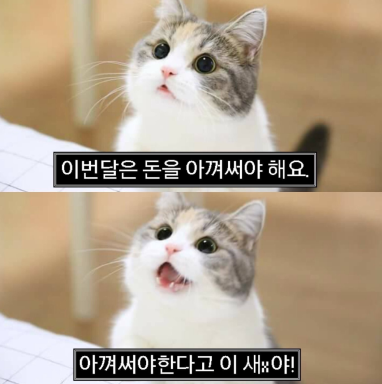

In [61]:
Image.open(testset[idx])